# Discourse-Aware Sentiment Analysis Using Latent-Variable Structural SVM

**Targeted Results**

| Corpus | Macro-$F_1$ | Micro-$F_1$ |
|--------|-------------|-------------|
| PotTS  |    0.677    |    0.706    |
| SB10k  |    0.559    |    0.713    |


## Structural SVM

In structured prediction, the goal is to predict a structured object $\mathbf{y} \in \mathcal{Y}(\mathbf{x})$ (such as a sequence of tags) for a given input $\mathbf{x} \in \mathcal{X}$. In the standard approach, a structured
feature map $\mathbf{\phi} : \mathcal{X} \times \mathcal{Y} \mapsto \mathbb{R}^d$ encodes the relevant information for input/output pairs, and a linear classifier with parameter $\mathbf{w}$ is defined by $h_{\mathbf{w}}(\mathbf{x}) = \arg\max_{\mathbf{y}\in\mathcal{Y}}\mathbf{w}\cdot\mathbf{\phi}\left(\mathbf{x}, \mathbf{y}\right)$. Given a labeled training set $\mathcal{D} := \left\{\left(\mathbf{x}_i, \mathbf{y}_i\right)\right\}_{i=1}^n$, $\mathbf{w}$ is estimated by solving:

$$\min_{\mathbf{w},\mathbf{\xi}}\frac{\lambda}{2}\lVert\mathbf{w}\rVert^2 + \frac{1}{n}\sum_i\xi_i$$
s.t. $$\mathbf{w}\cdot\mathbf{\psi}_i(\mathbf{y})\geq L(\mathbf{y}_i, \mathbf{y}) - \xi_i, \forall i, \forall\mathbf{y}\in\mathcal{Y}(\mathbf{x}),$$

where $\mathbf{\psi}_i(\mathbf{y}):=\mathbf{\phi}(\mathbf{x}, \mathbf{y}_i) - \mathbf{\phi}(\mathbf{x}, \mathbf{y})$ and $L_i(\mathbf{y}) := L(\mathbf{y}_i, \mathbf{y})$ denotes the task-dependent structured error of predicting output $\mathbf{y}$ instead of the observed output $\mathbf{y}_i$ (typically a Hamming distance between the two label sequences).

## Block-Coordinate Frank-Wolfe Optimization

As noted by [Lacoste-Julien et al. (2013)](https://arxiv.org/pdf/1207.4747.pdf), the above constraint can be satisfied by ensuring that the probability of the most likely label assignment $\mathbf{y} \neq \mathbf{y}_i$ for the $i$-th instance is at least $L(\mathbf{y}, \mathbf{y}_i) - \xi_i$ less than the probability of the correct labeling ($\mathbf{y}_i$).  Given an efficient *max oracle* for finding the most violating label assignment:
$$\tilde{H}_i(\mathbf{w}) := \max_{\mathbf{y}\in\mathcal{Y}_i}L_i(\mathbf{y}) - \mathbf{w}\cdot\mathbf{\psi}_i(\mathbf{y}),$$
we can rewrite the above constraint as:
$$ \xi_i \geq \tilde{H}_i(\mathbf{w}),$$
and maximize it iteratively by taking convex steps in the direction of the subgradient $\nabla_{\mathbf{w}}\tilde{H}_i(\mathbf{w})$, which is $-\mathbf{\psi}(\mathbf{y})$ (Frank-Wolfe algorithm).

## Expectation

This method, however, can hardly be applied to the cases where gold labels are only partially observed in the data, because the complete sequence $\mathbf{y}_i$ is underspecified in this case and the two most straightforward remedies to this problem---leaving missing labels empty or filling them with some guessed values---are unacceptable as they either lead to extremely small values for all features associated with the latent states (former case) or let the model learn unjustifiably strong correlations with actually unknown outputs (second case).

To avoid both of these hindrances (i.e., to allow the model to learn proper weights for latent-state features, but at the same time prevent it from excessively committing itself to the unknown labels), we propose the following modification of the above *max-oracle* definition:

* First of all, we restrict the prediction loss only to the labels which are actually observed in the data, i.e., $$L_i(\mathbf{y}) = \sum_{j=1}^m
\begin{cases}
1 - \delta\left(\mathbf{y}_{i,j}, \mathbf{y}_{j}\right),& \mbox{ if } \mathbf{y}_{i,j}\in\mathcal{Y}^o\\
0, & \mbox{otherwise;}
\end{cases}$$

* Secondly, we redefine the linear classifier to a conditional random field by exponentiating the dot product of the weight and feature vectors and dividing the resulting value by the normalization factor $Z:=\sum_{\mathbf{^*y}\in|\mathcal{Y}|^m}\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k(y_t, y_{t-1}, \mathbf{x}, \mathbf{^*y})\right\}$:

$$P(\mathbf{y}_i|\mathbf{x}_i) := \frac{1}{Z}\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k(y_t, y_{t-1}, \mathbf{x}, \mathbf{y}_i)\right\};$$

* Finally, we replace the $\mathbf{w}⋅\psi_i(\mathbf{y})$ term by the difference between marginal distributions:
$$P(\mathbf{y}^o_i|\mathbf{x}) = \frac{1}{Z}\sum_{\mathbf{y}^h}\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o_i,\mathbf{y}^h\right]\right)\right\}$$
and
$$P(\mathbf{y}^o|\mathbf{x}) = \frac{1}{Z}\sum_{\mathbf{y}^h}\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o,\mathbf{y}^h\right]\right)\right\}$$
arriving at:
$$P(\mathbf{y}^o_i|\mathbf{x}) -  P(\mathbf{y}^o|\mathbf{x}) = \frac{1}{Z}\sum_{\mathbf{y}^h}\left[
\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o_i,\mathbf{y}^h\right]\right)\right\}
- \exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o, \mathbf{y}^h\right]\right)\right\}\right]$$

Now we can optimize the last objective by computing the partial derivative of that expression w.r.t. $\theta_k$.  Let
$$a := \exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o_i,\mathbf{y}^h\right]\right)\right\}$$
and
$$b:=\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o,\mathbf{y}^h\right]\right)\right\},$$
then we obtain:
$$\frac{\partial}{\partial\theta_k} a = a\sum_{t=1}^m f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o_i,\mathbf{y}^h\right]\right),$$
$$\frac{\partial}{\partial\theta_k} b = b\sum_{t=1}^m f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o,\mathbf{y}^h\right]\right),$$
$$\frac{\partial}{\partial\theta_k} Z = \sum_{\mathbf{^*y}\in|\mathcal{Y}|^m}\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k(y_t, y_{t-1}, \mathbf{x}, \mathbf{^*y})\right\}\sum_{t=1}^m f_k(y_t, y_{t-1}, \mathbf{x}, \mathbf{^*y}),$$
arriving at:
$$\frac{\partial}{\partial\theta_k}\left(P(\mathbf{y}^o_i|\mathbf{x}) -  P(\mathbf{y}^o|\mathbf{x})\right)
= \sum_{\mathbf{y}^h}\frac{
\left(\frac{\partial}{\partial\theta_k}a - \frac{\partial}{\partial\theta_k} b\right)Z
- \left(a - b\right)\frac{\partial}{\partial\theta_k} Z
}{Z^2}$$

#### Quotient Alternative

Alternatively, instead of trying to maximize the difference between the marginals, we can try to maximize the ratio of these probabilities:

$$\frac{P(\mathbf{y}^o_i|\mathbf{x})}{P(\mathbf{y}^o|\mathbf{x})} = \frac{\frac{1}{Z}\sum_{\mathbf{y}^h}\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o_i,\mathbf{y}^h\right]\right)\right\}}{\frac{1}{Z}\sum_{\mathbf{y}^h}\exp\left\{\sum_{t=1}^m\sum_{k=1}^K\theta_{k}f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o,\mathbf{y}^h\right]\right)\right\}} = \frac{\sum_{\mathbf{y}^h}a}{\sum_{\mathbf{y}^h}b}$$

getting the derivative:

$$\frac{\partial}{\partial\theta_k} \frac{P(\mathbf{y}^o_i|\mathbf{x})}{P(\mathbf{y}^o|\mathbf{x})}
=\frac{\left(\sum_{\mathbf{y}^h}\frac{\partial}{\partial\theta_k}a\right) \left(\sum_{\mathbf{y}^h}b\right)
- \left(\sum_{\mathbf{y}^h}a\right)\left(\sum_{\mathbf{y}^h}\frac{\partial}{\partial\theta_k}b\right)}{\left(\sum_{\mathbf{y}^h}b\right)^2}
=\frac{\left(\sum_{\mathbf{y}^h}a\sum_{t=1}^m f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o_i,\mathbf{y}^h\right]\right)\right) \left(\sum_{\mathbf{y}^h}b\right)
- \left(\sum_{\mathbf{y}^h}a\right)\left(\sum_{\mathbf{y}^h}b\sum_{t=1}^m f_k\left(y_t, y_{t-1}, \mathbf{x}, \left[\mathbf{y}^o,\mathbf{y}^h\right]\right)\right)}{\left(\sum_{\mathbf{y}^h}b\right)^2}
$$

#### Final Formulation

$$a = \exp\left\{\sum_{t=1}^{T}\sum_{k=1}^{K}\theta_k f_k(y_t, y_{t-1},\mathbf{x}, [\mathbf{y}^o_i, \mathbf{y}_h])\right\}$$

$$\frac{\partial}{\partial\theta_k}a 
= a\frac{\partial}{\partial\theta_k}\sum_{t=1}^{T}\sum_{k=1}^{K}\theta_kf_k(y_t, y_{t-1},\mathbf{x}, [\mathbf{y}^o_i, \mathbf{y}_h])
= a\sum_{t=1}^{T}f_k(y_t, y_{t-1},\mathbf{x}, [\mathbf{y}^o_i, \mathbf{y}_h])\propto\mathbb{E}_{[\mathbf{y}^o_i, \mathbf{y}_h]}[f_k]$$

Let $a_{\mathbf{y}_h}$ be $\sum_{\mathbf{y}_h}a$ and $b_{\mathbf{y}_h}$ denote $\sum_{\mathbf{y}_h}b$, then our objective function becomes:

$$\frac{a_{\mathbf{y}_h}}{b_{\mathbf{y}_h}}$$

and the derivative of it can be written as:

$$\frac{\partial}{\partial\theta_k}\frac{a_{\mathbf{y}_h}}{b_{\mathbf{y}_h}}
= \frac{\frac{\partial}{\partial\theta_k}a_{\mathbf{y}_h}b_{\mathbf{y}_h} - a_{\mathbf{y}_h}\frac{\partial}{\partial\theta_k}b_{\mathbf{y}_h}}{b_{\mathbf{y}_h}^2}$$

## Code

In [3]:
from __future__ import absolute_import, print_function, unicode_literals

# Discourse-Aware Sentiment Analysis Using Dirichlet Process

### Plotting Utils

In [172]:
%matplotlib inline
from scipy.stats import beta, dirichlet, entropy

from string import ascii_lowercase
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd
import seaborn as sns
import math

LGND_FS = 10
LBL_FS = 16

# sns.set_context("notebook", rc={"figure.dpi": 120})
sns.set_context("paper", rc={"figure.dpi": 300, "xtick.labelsize": LGND_FS,
                             "ytick.labelsize": LGND_FS, "legend.fontsize": 20,
                             "axes.labelsize": LBL_FS})


In [5]:
EPSILON = 1e-2
M = np.eye(3)
M[1,1] = 0.5


def scale(a, b):
    z = np.maximum(0.1, a + b)
    print("z", repr(z))
    z /= np.sum(z)
    print("z*", repr(z))
    print("entropy z*", entropy(z))
    print("1 - z*", repr(1 - z))
    cos_ab = 1.
    if np.sum(a) and np.sum(b):
        cos_ab = (a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b)))
        cos_ab = min(1., max(EPSILON * 10., cos_ab))
    print("cos_ab", repr(cos_ab))
    s = 42  * cos_ab / entropy(z)
    print("scale", repr(s))
    return s


def join(a, b):
    print("b", b)
    print("M", M)
    b = b.dot(M)
    
    t = 0.5  # beta.rvs(a=15, b=15, size=a.shape[0]) * np.sum(b)
    mu_a = (1 - t) * np.sum(a) * a
    mu_b = t * b
    mu = mu_a + mu_b + EPSILON
    print("mu", repr(mu))
    alpha = mu * scale(a, b)
    print(alpha)
    return dirichlet(alpha)

In [194]:
CORNERS = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
MIDPOINTS = [(CORNERS[(i + 1) % 3] + CORNERS[(i + 2) % 3]) / 2.0 \
             for i in range(3)]


def array2string(array):
    return np.array2string(array, separator=", ")


def xy2bc(xy, tol=1.e-10):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(CORNERS[i] - MIDPOINTS[i]).dot(xy - MIDPOINTS[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


def draw_pdf_contours(ax, prnt_prob, chld_prob, title, nlevels=200, subdiv=8,  **kwargs):
    print("=======================================================")
    print("prnt_prob", prnt_prob)
    print("chld_prob", chld_prob)
    dist = join(prnt_prob, chld_prob)

    triangle = tri.Triangulation(CORNERS[:, 0], CORNERS[:, 1])
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    kwargs.setdefault("cmap", "RdBu_r")
    ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
    ax.axis('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.75**0.5)
    ax.axis('off')
    lbl_fs = 13
    ax.annotate("Negative", xy=(0, 0), xytext=(-0.16, -0.09), fontsize=lbl_fs)
    ax.annotate("Positive", xy=(1., 0.), xytext=(0.34, 0.89), fontsize=lbl_fs)
    ax.annotate("Neutral", xy=(1, 0), xytext=(0.85, -0.09), fontsize=lbl_fs)
    # add title
    ax.annotate(title, xy=(1, 0), xytext=(0.49, -0.16), fontsize=LBL_FS)
    # ax.colorbar()
    alpha = array2string(dist.alpha)
    mu = array2string(dist.mean())
    sigma2 = array2string(dist.var())
    ax.text(0.8, 0.55,
            ("$\\mathbf{{p_{{prnt}}}}$: {}\n"
             "$\\mathbf{{p_{{chld}}}}$: {}\n"
             "$\\mathbf{{\\alpha}}$: {}\n"
             "$\\mathbf{{\\mu}}$: {}\n"
             "$\\mathbf{{\\sigma^2}}$: {}").format(
            prnt_prob, chld_prob, alpha, mu, sigma2), fontsize=LGND_FS - 2)

prnt_prob [1. 0. 0.]
chld_prob [0.333 0.333 0.333]
b [0.333 0.333 0.333]
M [[1.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]
mu array([0.6765 , 0.09325, 0.1765 ])
z array([1.333 , 0.1665, 0.333 ])
z* array([0.72742156, 0.09085948, 0.18171896])
entropy z* 0.7593066296788314
1 - z* array([0.27257844, 0.90914052, 0.81828104])
cos_ab 0.6666666666666666
scale 36.875748091180675
[24.94644358  3.43866351  6.50856954]
prnt_prob [1. 0. 0.]
chld_prob [0. 0. 1.]
b [0. 0. 1.]
M [[1.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]
mu array([0.51, 0.01, 0.51])
z array([1. , 0.1, 1. ])
z* array([0.47619048, 0.04761905, 0.47619048])
entropy z* 0.8515842539195699
1 - z* array([0.52380952, 0.95238095, 0.52380952])
cos_ab 0.1
scale 4.931984099833626
[2.51531189 0.04931984 2.51531189]
prnt_prob [0.8 0.1 0.1]
chld_prob [0.1 0.1 0.8]
b [0.1 0.1 0.8]
M [[1.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]
mu array([0.46 , 0.085, 0.46 ])
z array([0.9 , 0.15, 0.9 ])
z* array([0.46153846, 0.07692308, 0.46153846])
entropy z* 0.911

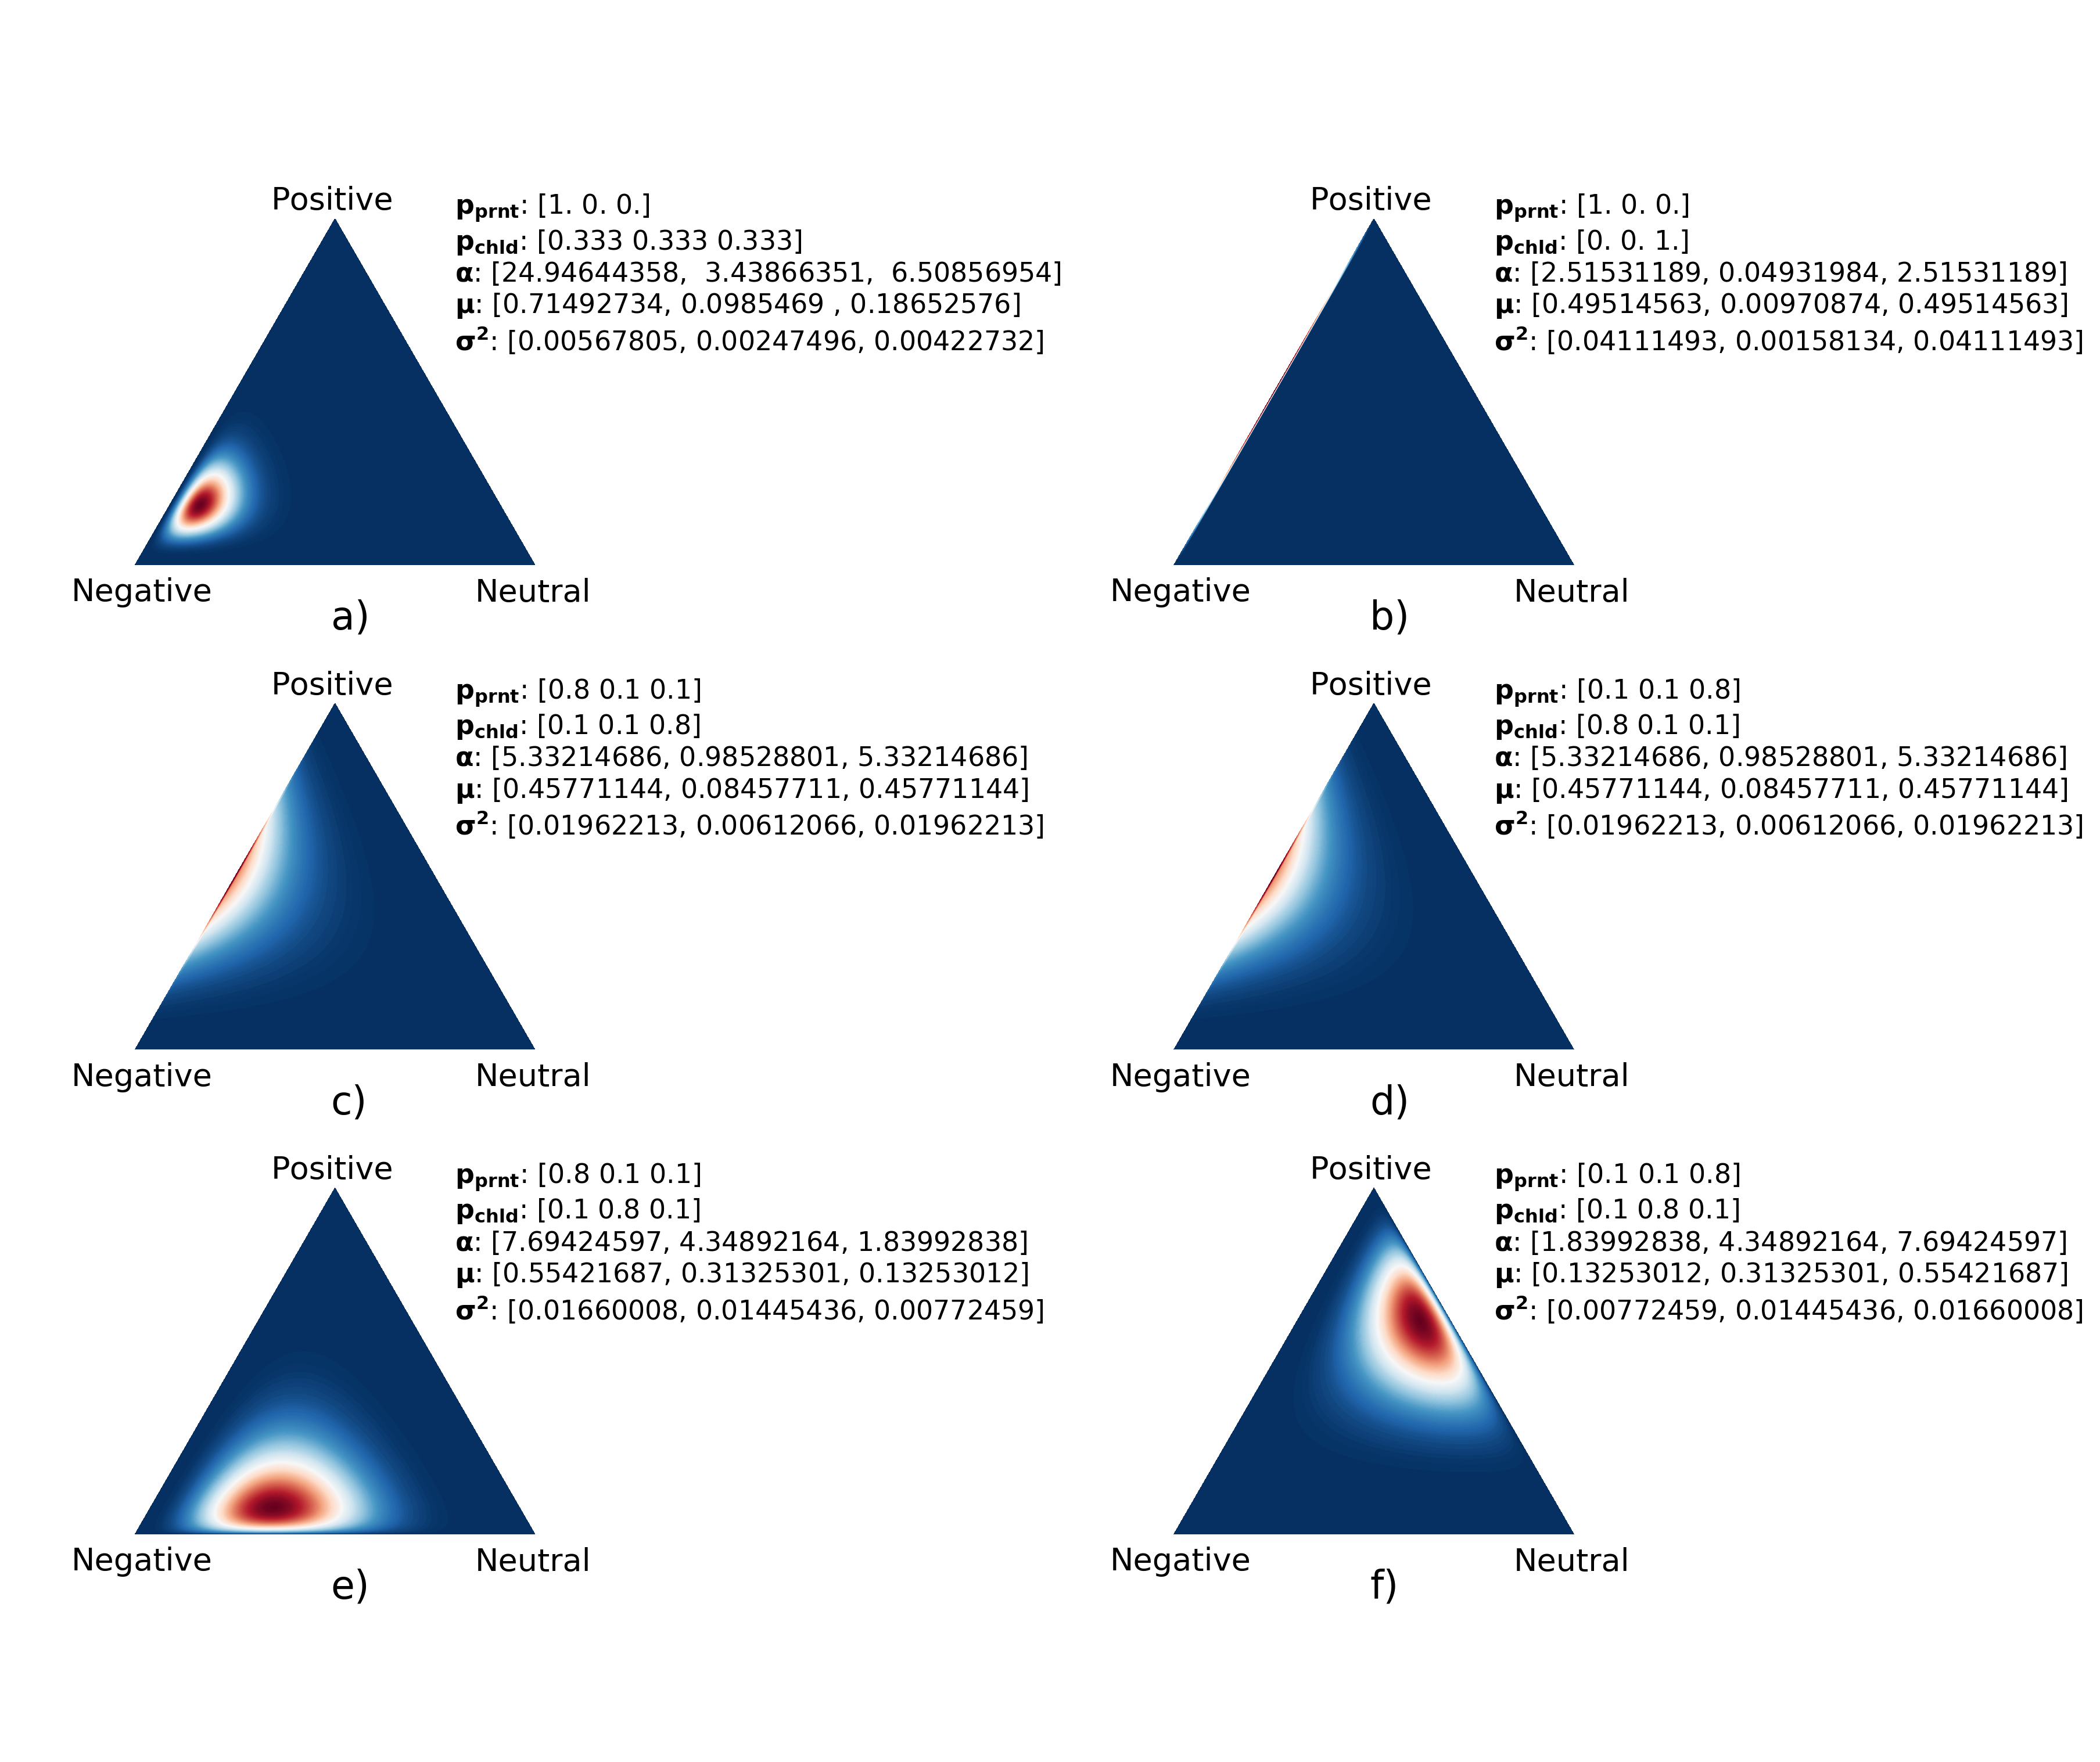

In [198]:
D = np.array([
    [[1., 0., 0.], [0.333, 0.333, 0.333]],
    [[1., 0., 0.], [0., 0., 1.]],
    [[0.8, 0.1, 0.1], [0.1, 0.1, 0.8]],
    [[0.1, 0.1, 0.8], [0.8, 0.1, 0.1]],
    [[0.8, 0.1, 0.1], [0.1, 0.8, 0.1]],
    [[0.1, 0.1, 0.8], [0.1, 0.8, 0.1]]
])

LBL_FS = 16
LGND_FS = 13
sns.set_context("paper", rc={"xtick.labelsize": LGND_FS, "ytick.labelsize": LGND_FS,
                             "legend.fontsize": 20, "dpi": 300})

fig, axes = plt.subplots(nrows=int(np.ceil(D.shape[0] / 2)), ncols=2,
                         figsize=(10, 10), constrained_layout=True,
                         dpi=300)
axes = axes.flatten()

for ax, (a, b), c in zip(axes, D, ascii_lowercase):
    draw_pdf_contours(ax, a, b, c + ')')
    
plt.subplots_adjust(left=0.02, wspace=1.1, hspace=0.4)
plt.savefig("dirichlet-process.png")
plt.show()

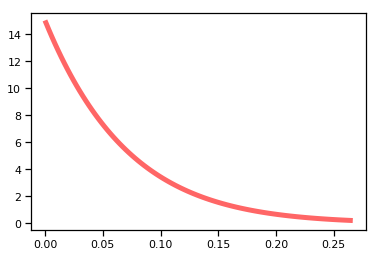

In [8]:
fig, ax = plt.subplots(1, 1)
a = 1
b = 15
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')

[[0.49292928]
 [0.24297927]
 [0.1197716 ]
 [0.05903893]
 [0.02910202]
 [0.01434524]
 [0.00707119]
 [0.00348559]
 [0.00171815]
 [0.00084693]]
MTX: [[ 7.   0.2  1. ]
 [14.   0.4  2. ]
 [21.   0.6  3. ]
 [28.   0.8  4. ]
 [35.   1.   5. ]
 [42.   1.2  6. ]
 [49.   1.4  7. ]
 [56.   1.6  8. ]
 [63.   1.8  9. ]
 [70.   2.  10. ]]
MTX*: [[1.06008201e-01 3.60573772e-02 4.42868859e-02]
 [5.04180833e-01 8.04623095e-02 1.30311548e-01]
 [1.64533722e+00 1.46095349e-01 3.22476745e-01]
 [4.59863360e+00 2.63503817e-01 7.73519086e-01]
 [1.18466583e+01 5.03618809e-01 1.83809405e+00]
 [2.90620133e+01 1.02851467e+00 4.32657333e+00]
 [6.90433001e+01 2.20386572e+00 1.00673286e+01]
 [1.60373239e+02 4.84632112e+00 2.31436056e+01]
 [3.66349075e+02 1.07643736e+01 5.25978678e+01]
 [8.26157202e+02 2.39347772e+01 1.18313886e+02]]
    $\sigma^2$              f(x)   |x|
0     9.208889        $\sigma^2$   8.2
1    36.835556        $\sigma^2$  16.4
2    82.880000        $\sigma^2$  24.6
3   147.342222        $\sigma^

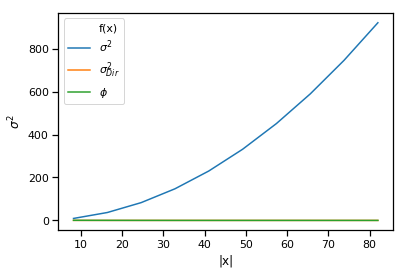

In [9]:
# Uniformity Function
def dirichlet_sigma(x, axis=1):
    s = np.asmatrix(np.sum(x, axis=axis)).T
    num = np.sum(np.multiply(x, (s - x)), axis=axis)
    denom = np.maximum(1e-5, np.multiply(np.power(s, 2), (s + 1)))
    return np.squeeze(np.asarray(num / denom))


def normalize(x, axis=1):
    mu = np.mean(x, axis=axis).reshape(-1, 1)
    sigma = np.power(np.std(x, axis=axis).reshape(-1, 1), 1)
    x -= np.multiply(x - mu, 1./sigma)
    return x


def phi(x, axis=1):
    imax = np.max(x, axis=axis).reshape(-1, 1)
    imin = np.min(x, axis=axis).reshape(-1, 1)
    inorm = np.exp(-0.1 * np.linalg.norm(x, axis=axis).reshape(-1, 1))
    print(inorm)
    middle = (imax - imin) / 2
    delta = middle - x
    print("MTX:", x)
    x += delta * inorm
    x /= 100 * inorm
    print("MTX*:", x)
    return x


MTX = np.multiply(np.array([[7, 0.2, 1],]).repeat(10, axis=0),
                  np.arange(1, 11).reshape(10, 1))
x = np.tile(np.sum(MTX, axis=1), 3)
y = np.concatenate([np.power(np.std(MTX, axis=1), 2),
                    dirichlet_sigma(MTX),
                    dirichlet_sigma(phi(MTX))])
f_x = ["$\sigma^2$"] * 10 + ["$\sigma^2_{Dir}$"] * 10 + ["$\phi$"] * 10
dframe = pd.DataFrame({"|x|": x, r"$\sigma^2$": y, r"f(x)": f_x})
print(dframe)
sns.lineplot(x="|x|", y=r"$\sigma^2$", hue=r"f(x)", data=dframe)

In [10]:
from scipy.stats import dirichlet

# for r in MTX:
    # print(r)
    # print(dirichlet(r).var().sum())
    
dirichlet([0.005] * 3).var()

array([0.21893815, 0.21893815, 0.21893815])

### Key Requirements Concerning the Join Function:

 - if the polarities of parent and child agree, we want to reduce the variance of the resulting distribution while keeping its mean within the respective polarity corner;
 - if the polarities of parent and child disagree, we want to increase the variance and push the mean of the parent towards the polarity of the child;
 - neutral polarity should have less affect

## Visualization of the Recursive Dirichlet Process

In [103]:
import daft

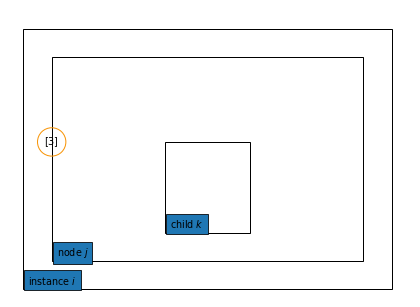

In [154]:
# Colors.
p_color = {"ec": "#46a546"}
s_color = {"ec": "#f89406"}

pgm = daft.PGM([7, 5], origin=[0.3, 0.3])

n = daft.Node("x", r"$[3]$", 1, 3, plot_params=s_color)
n.va = "baseline"
pgm.add_node(n)
# pgm.add_node(daft.Node("speckle_coeff", r"$z_i$", 2, 3, plot_params=s_color))
# pgm.add_node(daft.Node("speckle_img", r"$x_i$", 2, 2, plot_params=s_color))

# pgm.add_node(daft.Node("spec", r"$s$", 4, 3, plot_params=p_color))
# pgm.add_node(daft.Node("shape", r"$g$", 4, 2, plot_params=p_color))
# pgm.add_node(daft.Node("planet_pos", r"$\mu_i$", 3, 3, plot_params=p_color))
# pgm.add_node(daft.Node("planet_img", r"$p_i$", 3, 2, plot_params=p_color))

# pgm.add_node(daft.Node("pixels", r"$y_i ^j$", 2.5, 1, observed=True))

# Edges.
# pgm.add_edge("phi", "speckle_coeff")
# pgm.add_edge("speckle_coeff", "speckle_img")
# pgm.add_edge("speckle_img", "pixels")

# pgm.add_edge("spec", "planet_img")
# pgm.add_edge("shape", "planet_img")
# pgm.add_edge("planet_pos", "planet_img")
# pgm.add_edge("planet_img", "pixels")

# And a plate.
pgm.add_plate(daft.Plate([0.5, 0.5, 6.5, 4.5], label=r"instance $i$", shift=-0.1))
pgm.add_plate(daft.Plate([1, 1, 5.5, 3.5], label=r"node $j$", shift=-0.1))
pgm.add_plate(daft.Plate([3, 1.5, 1.5, 1.5], label=r"child $k$", shift=-0.1))

# Render and save.
pgm.render()

### Effect of the Relation Scheme

In [159]:
REL_SCHEMES = ["Bhatia et al. (2015)", "Chenlo et al. (2013)", "Heerschop et al. (2011)", 
               "PCC", "Zhou et al. (2011)"]
CLASSIFIERS = ["LCRF", "LMCRF", "RDP", "WNG", "DDR", "R2N2", "Last", "Root"]

potts_data = {"Relation Scheme": REL_SCHEMES * len(CLASSIFIERS),
              "Classifier": [clf for _ in range(len(REL_SCHEMES)) for clf in CLASSIFIERS],
              r"Potts Macro-$F_1$":
              # Bhatia
              [0.67, 0.671, 0.672, 0.487, 0.655, 0.657, 0.453, 0.481]
              # Chenlo
              + [0., 0., 0., 0., 0., 0., 0., 0.]
              # Heerschop
              + [0., 0., 0., 0., 0., 0., 0., 0.]
              # PCC
              + [0., 0., 0., 0., 0., 0., 0., 0.]
              # Zhou
              + [0., 0., 0., 0., 0., 0., 0., 0.],
              r"Potts Micro-$F_1$": 
              # Bhatia
              [0.709, 0.712, 0.694, 0.59, 0.674, 0.692, 0.549, 0.56]
              # Chenlo
              + [0., 0., 0., 0., 0., 0., 0., 0.]
              # Heerschop
              + [0., 0., 0., 0., 0., 0., 0., 0.]
              # PCC
              + [0., 0., 0., 0., 0., 0., 0., 0.]
              # Zhou
              + [0., 0., 0., 0., 0., 0., 0., 0.]
             }
potts_df = pd.DataFrame.from_dict(potts_data)
potts_df

,Classifier,Potts Macro-$F_1$,Potts Micro-$F_1$,Relation Scheme
0,LCRF,0.670,0.708,Bhatia et al. (2015)
1,LMCRF,0.662,0.713,Chenlo et al. (2013)
2,RDP,0.672,0.694,Heerschop et al. (2011)
3,WNG,0.487,0.590,PCC
4,DDR,0.655,0.674,Zhou et al. (2011)
5,R2N2,0.657,0.692,Bhatia et al. (2015)
6,Last,0.453,0.549,Chenlo et al. (2013)
7,Root,0.481,0.560,Heerschop et al. (2011)
8,LCRF,0.000,0.000,PCC
9,LMCRF,0.000,0.000,Zhou et al. (2011)
